<a href="https://colab.research.google.com/github/inesbsilveira/2nd-semester-2023/blob/main/IS_MC_code_img_segmentation_07092023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Code for Image segmentation task for Practical Machine Learning
#### Inês Silveira nr. 22062


## First of all, download the files **mask_reclass.tif** and **3bands_clipped_tif.tif**, from the Data_In folder, to path /content/drive/MyDrive/AAA/ in Google Colab.

## Imports

In [1]:
user='I' # escolher 'M' ou 'I'
N_epochs=20
target_names = ['not greenhouse', 'greenhouse']
Nrows,Ncols = 20, 8 # número de blocos a usar 20*8=160

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install rasterio

import rasterio
from rasterio.windows import Window
import os
import shutil
import numpy as np
from PIL import Image

from fastai.vision.all import *
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.2 MB/s eta 0:00:00


## RASTERIO

### RASTERIO - 1 BAND IMAGE
Used to clip the mask_reclass.tif into smaller images. It creates a folder named "labels1" and stores all the 160 clipped images inside.

In [3]:
# Specify the directory path
if user=='M':
  directory = '/content/drive/MyDrive/inv_proj/S2change_DGT/Estufas_Alentejo'
else:
  directory = '/content/drive/MyDrive/AAA/'

# Create a folder named "labels1" if it doesn't exist
folder_name = "labels"
folder_path = os.path.join(directory, folder_name)
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)  # Delete the folder and its contents

os.makedirs(folder_path)  # Create the folder

# Open the input raster file
#with rasterio.open('/content/drive/MyDrive/AAA/mask_reclass.tif') as src:
with rasterio.open(os.path.join(directory,'mask_3763_reclass.tif')) as src:

    # Calculate the height and width of the sub-rasters
    height = src.height // 20  # Divide the raster into 4 rows
    width = src.width // 8  # Divide the raster into 8 columns

    # Loop through each sub-raster and clip the data
    for i in range(20):
        for j in range(8):
            # Define the window to clip the sub-raster
            ymin = i * height
            ymax = (i + 1) * height
            xmin = j * width
            xmax = (j + 1) * width
            window = Window.from_slices((ymin, ymax), (xmin, xmax))

            # Read the data within the window
            clipped_data = src.read(window=window)

            # Update the metadata for the clipped data
            clipped_meta = src.meta.copy()
            clipped_meta.update({
                'height': window.height,
                'width': window.width,
                'transform': src.window_transform(window)
            })

            # Write the clipped data to a new raster file
            # with rasterio.open(f'sub_raster_{i}_{j}.tif', 'w', **clipped_meta) as dst:
            output_file = os.path.join(directory,folder_name, f'image_{i}_{j}_mask.png')
            with rasterio.open(output_file, 'w', **clipped_meta) as dst:
                 dst.write(clipped_data)

  # converts to 8 bits AFTER re-scaling bands
def s255(arr):
    arr_std = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) * 255
    # Convert the standardized array to integer values
    arr_std = arr_std.astype(np.uint8)
    return arr_std

### RASTERIO - 3 BANDS IMAGE
Used to clip the 3bands_clipped_tif.tif into smaller images. It creates a folder named "images" and stores all the 160 clipped images inside.

In [4]:
# Specify the directory path
# directory = '/content/drive/MyDrive/AAA/'

# Create a folder named "images" if it already doesn't exist
folder_name = "images"
folder_path = os.path.join(directory, folder_name)
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)  # Delete the folder and its contents

os.makedirs(folder_path)  # Create the folder

# Multi bandas
# Open the input raster file
with rasterio.open(os.path.join(directory,'3bands_clipped_tif.tif')) as src:

    # Calculate the height and width of the sub-rasters
    nHeight=Nrows
    nWidth=Ncols
    height = src.height // nHeight  # Divide the raster into 58 rows
    width = src.width // nWidth  # Divide the raster into 23 columns

    # Loop through each sub-raster and clip the data
    for i in range(nHeight):
        for j in range(nWidth):
            # Define the window to clip the sub-raster
            ymin = i * height
            ymax = (i + 1) * height
            xmin = j * width
            xmax = (j + 1) * width

            window = Window.from_slices((ymin, ymax), (xmin, xmax))

            # Read the data within the window
            clipped_data_1 = s255(src.read(1, window=window))
            clipped_data_2 = s255(src.read(2, window=window))
            clipped_data_3 = s255(src.read(3, window=window))

            rgb_image = np.stack([clipped_data_1, clipped_data_2, clipped_data_3], axis=2)


            # Convert the image array to a PIL Image
            image = Image.fromarray(rgb_image,mode='RGB')

            # Save the PIL Image as a PNG file

            output_file = os.path.join(directory, folder_name, f'image_{i}_{j}.png')
            image.save(output_file)

## IMAGE SEGMENTATION
Uses images and labels created in the previous code, as well as a list of labels in the mask (greenhouse, not greenhouse)

In [5]:
# Define paths
#path = Path('/content/drive/MyDrive/AAA')
path=Path(directory)
image_folder = path/'images'
mask_folder = path/'labels'

# Create DataBlock
def get_items(path):
    image_files = get_image_files(image_folder)
    return image_files

def get_mask_fn(image_file):
    return mask_folder / f'{image_file.stem}_mask.png'

items = get_items(path)

dblock = DataBlock(blocks=(ImageBlock, MaskBlock(target_names)),
                   get_items=get_items,
                   get_y=get_mask_fn,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42))

# Create DataLoaders
dls = dblock.dataloaders(path, bs=8)

In [6]:
from pathlib import Path

# Create a stratified split of the indices for training and test set
train_idx, test_idx = RandomSplitter(valid_pct=0.2, seed=42)(items)
train_items = [items[i] for i in train_idx]
test_items = [items[i] for i in test_idx]

# Write the training set items to a txt file in the AAA folder
training_set_file = path / 'training_set.txt'
with open(training_set_file, 'w') as f:
    for item in train_items:
        f.write(str(item) + '\n')

# Write the test set items to a txt file in the AAA folder
test_set_file = path / 'test_set.txt'
with open(test_set_file, 'w') as f:
    for item in test_items:
        f.write(str(item) + '\n')

print("Paths of training and test sets have been stored in 'training_set.txt' and 'test_set.txt' respectively.")

Paths of training and test sets have been stored in 'training_set.txt' and 'test_set.txt' respectively.


Train the model

In [7]:
# Define U-Net model
learn = unet_learner(dls, resnet34)

# Train the model
# In the following line of code, adjust the number of epochs to see different results
learn.fine_tune(N_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 75.4MB/s]


epoch,train_loss,valid_loss,time
0,0.435030,0.356295,00:14


epoch,train_loss,valid_loss,time
0,0.327416,0.274728,00:02
1,0.317716,0.302864,00:01
2,0.303773,0.328867,00:01
3,0.296898,0.267496,00:01
4,0.273680,0.177972,00:02
5,0.264859,0.317575,00:02
6,0.254983,0.163016,00:01
7,0.234953,0.234774,00:01
8,0.208252,0.139567,00:01
9,0.182988,0.182247,00:01


Predictions:

torch.Size([160, 2, 58, 57]) None


<Axes: >

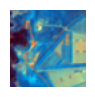

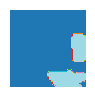

In [8]:
# Perform inference on test images
test_dl = dls.test_dl(get_image_files(image_folder)) # usa todas as 160 imagens em image_folder, treino e validação
preds = learn.get_preds(dl=test_dl)
print(preds[0].shape, preds[1])

# Display sample predictions
sample_idx = 0
sample_image_path = list(test_dl.items)[sample_idx]
sample_image = PILImage.create(sample_image_path)
sample_pred = preds[0][sample_idx].argmax(dim=0).numpy()

sample_image.show()
TensorImage(sample_pred).show(cmap='tab20')


In [9]:
# Perform inference on test images
test_dl = dls.test_dl(get_image_files(image_folder)) # todas as 160 imagens (não é só validação)
preds = learn.get_preds(dl=test_dl)[0]
preds.shape # 160 imagens, 2 classes, 58=nrows do bloco, 57=ncolumns do bloco

torch.Size([160, 2, 58, 57])

In [10]:
s=preds.shape
s[0]*s[2]*s[3]

528960

### Merge the block and save merge image of predicted mask

In [11]:
# Define the function to extract the row and column number from the test image file name
def get_row_column_from_filename(filename):
    filename = os.path.basename(filename)
    parts = filename.split('_')
    row = int(parts[1])
    column = int(parts[2].split('.')[0])
    return row, column

In [12]:
#get_row_column_from_filename('/content/drive/MyDrive/inv_proj/S2change_DGT/Estufas_Alentejo/images/image_12_6.png')

In [13]:
# Save the predicted mask images according to their row and column number
test_dl = dls.test_dl(get_image_files(image_folder)) # todas as 160 imagens (não é só validação)
#print(test_dl.items)
# Define paths to the "predicted" folders
predicted_folder = Path('/content/drive/MyDrive/AAA/predicted')

preds = learn.get_preds(dl=test_dl)[0]
for idx, pred in enumerate(preds):
    # Get the row and column number from the test image file name
    sample_image_path = list(test_dl.items)[idx]
    row, column = get_row_column_from_filename(sample_image_path)

    # Create a folder for each row if it doesn't exist
    row_folder = os.path.join(predicted_folder, f'row_{row}')
    os.makedirs(row_folder, exist_ok=True)

    # Create a filename for the predicted mask image
    predicted_filename = f'image_{row}_{column}_predicted.png'
    predicted_filepath = os.path.join(row_folder, predicted_filename)

    # Convert the predicted mask to a PIL Image
    sample_pred = pred.argmax(dim=0).numpy()
    predicted_image = Image.fromarray((sample_pred * 255).astype(np.uint8))

    # Save the predicted mask image
    predicted_image.save(predicted_filepath)

In [14]:
# Open the input raster file to calculate width and height
#with rasterio.open('/content/drive/MyDrive/AAA/mask_reclass.tif') as src:
with rasterio.open(os.path.join(directory,'mask_3763_reclass.tif')) as src:
    # Calculate the height and width of the sub-rasters
    height = src.height // Nrows  # Divide the raster into 4 rows
    width = src.width // Ncols  # Divide the raster into 8 columns

In [15]:
# Merge all predicted mask images according to their row and column
rows, columns = Nrows,Ncols # 20, 8  # Number of rows and columns in the grid
merged_width = width * columns
merged_height = height * rows
merged_image = Image.new('RGB', (merged_width, merged_height))

# Loop through each row and column to merge the images
for i in range(rows):
    for j in range(columns):
        # Load the predicted mask image
        predicted_file = os.path.join(predicted_folder, f'row_{i}', f'image_{i}_{j}_predicted.png')
        predicted_image = Image.open(predicted_file)

        # Define the position to paste the mask image in the merged image
        x_offset = j * width
        y_offset = i * height

        # Paste the mask image in the merged image
        merged_image.paste(predicted_image, (x_offset, y_offset))

# Save the merged image
merged_output_file = os.path.join(predicted_folder, 'merged_predicted_masks_20_1209.png')
merged_image.save(merged_output_file)


### Display satellite image, true mask and predicted mask

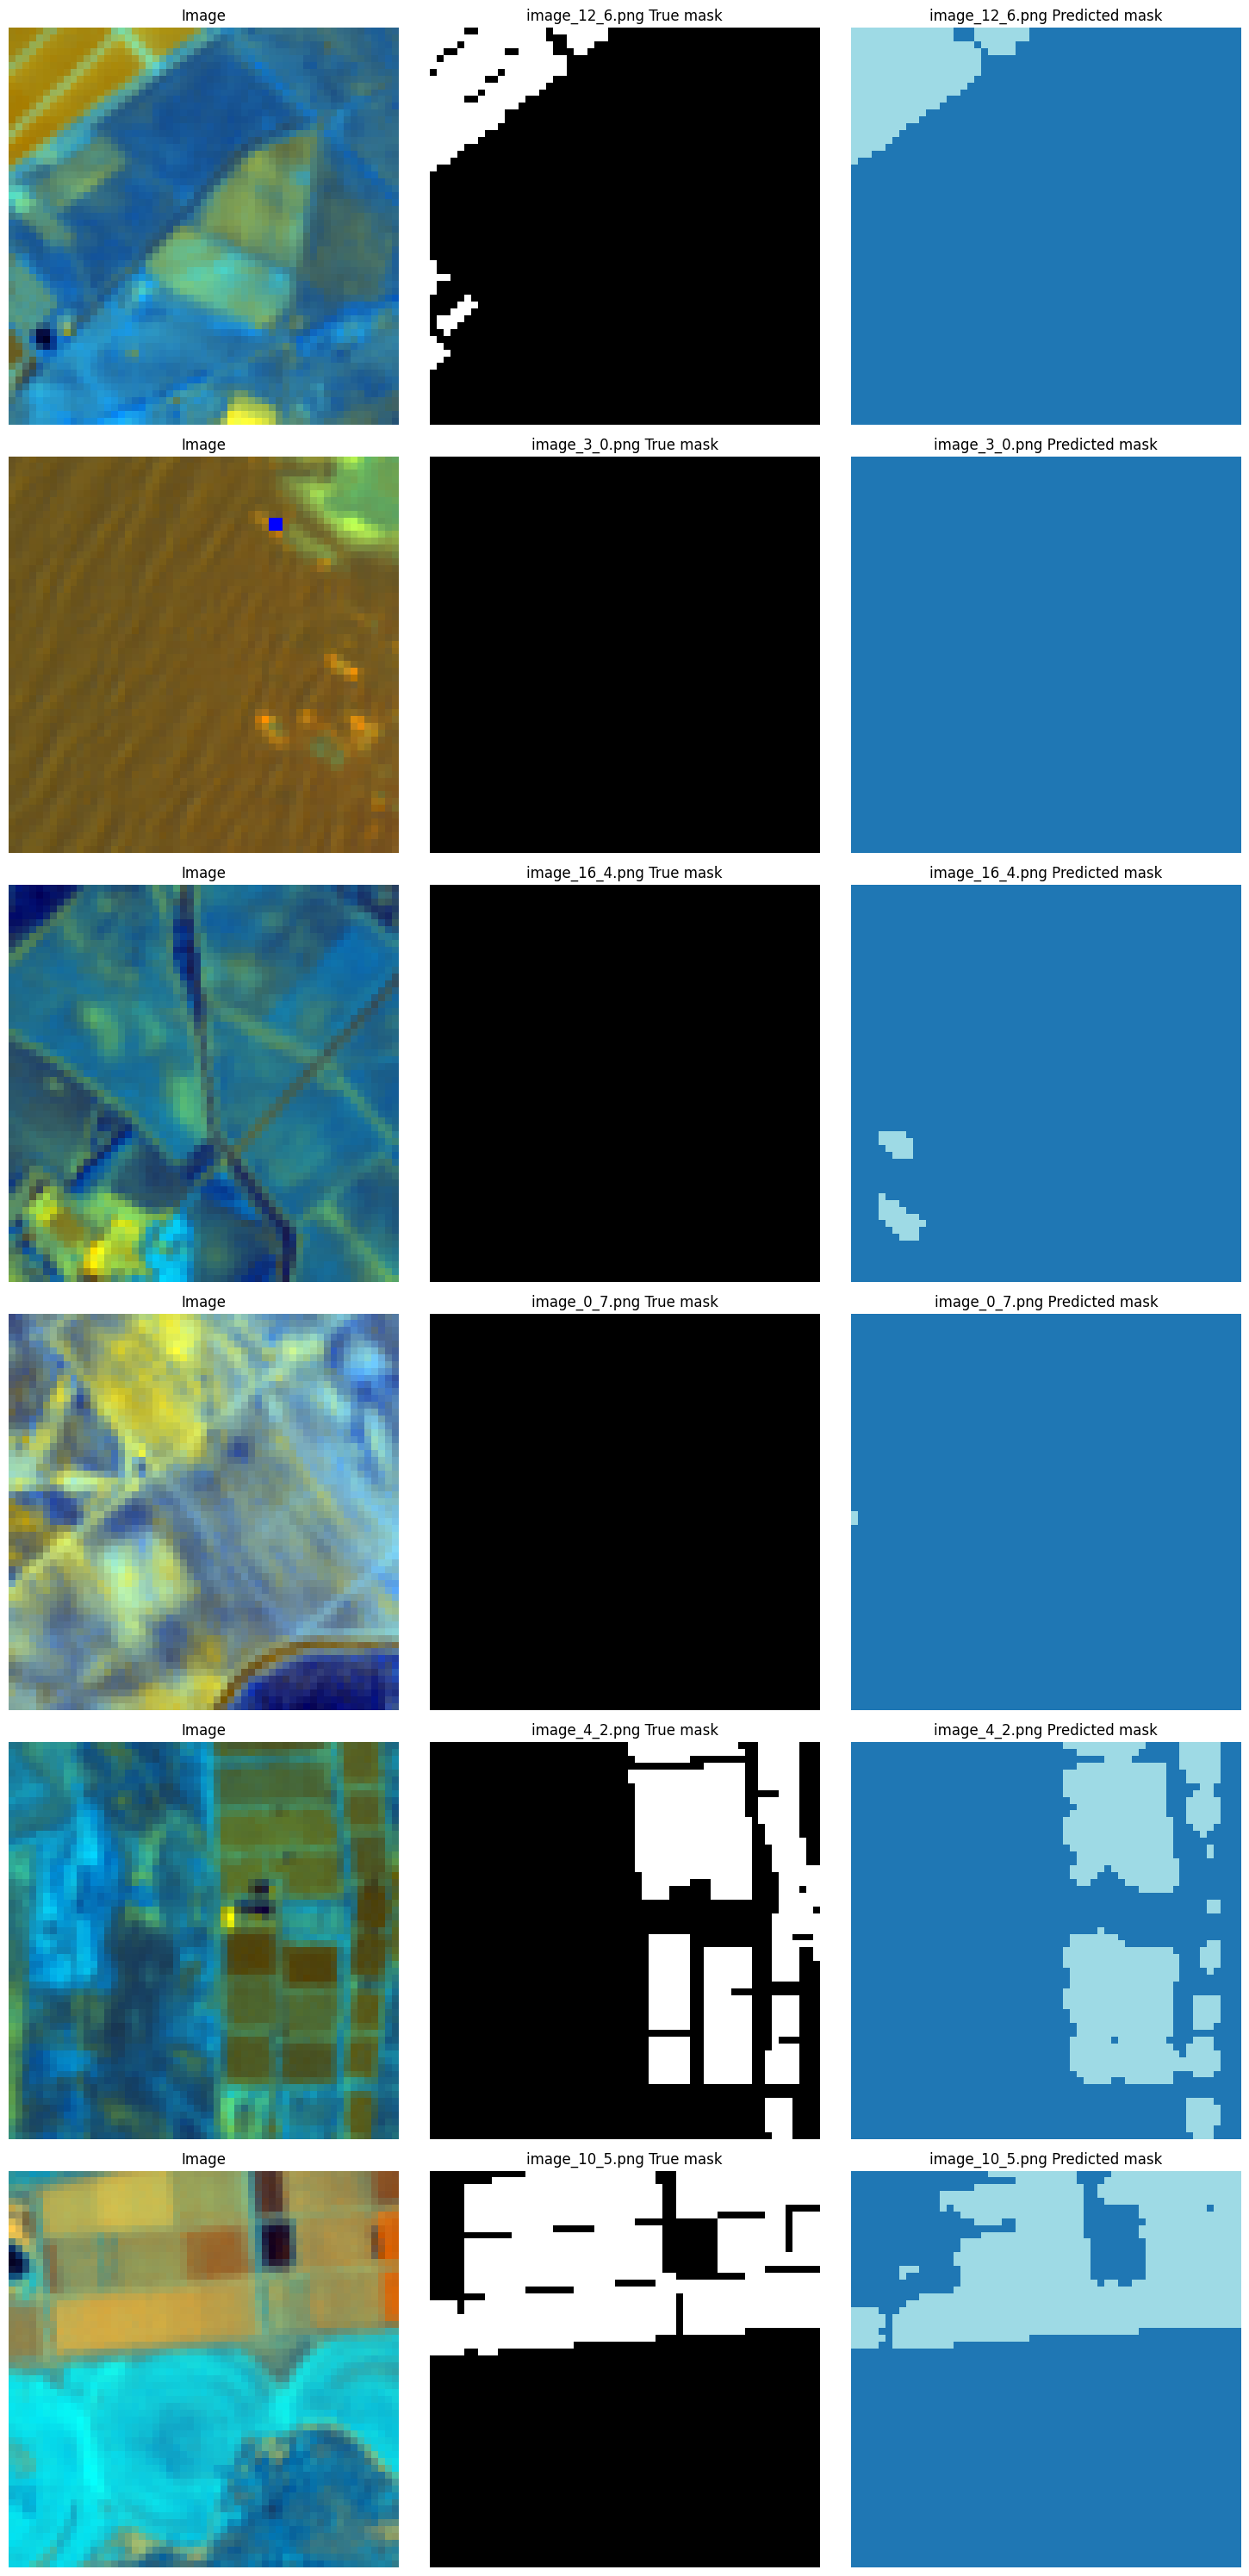

In [16]:
# Define paths to the "predicted" folders
predicted_folder = Path('/content/drive/MyDrive/AAA/predicted')

# Get the file names of the test set images
with open('/content/drive/MyDrive/AAA/test_set.txt', 'r') as f:
    test_set_files = [line.strip() for line in f]

# Display sample predictions using file names of test_set
sample_files = [Path(file_path).name for file_path in test_set_files]

# Slice the sample_files list to include only the first 6 samples
sample_files = sample_files[:6]

# Define the number of columns (including both true and predicted masks)
num_columns = 3

fig, axes = plt.subplots(len(sample_files), num_columns, figsize=(15, 5 * len(sample_files)))

for i, file_name in enumerate(sample_files):
    sample_image_path = image_folder / file_name
    sample_image = PILImage.create(sample_image_path)
    sample_pred = preds[i].argmax(dim=0).numpy()

    # Load the ground truth mask for the sample from the "labels" folder
    row, column = get_row_column_from_filename(file_name)
    mask_file = mask_folder / f'image_{row}_{column}_mask.png'
    true_mask = np.array(Image.open(mask_file))

    # Load the predicted mask for the sample from the "predicted" folder
    predicted_file = os.path.join(predicted_folder, f'row_{row}', f'image_{row}_{column}_predicted.png')
    pred_mask = np.array(Image.open(predicted_file))

    # image of satellite aggregate
    axes[i, 0].imshow(sample_image)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    # image of true mask
    axes[i, 1].imshow(true_mask, cmap='gray')
    axes[i, 1].set_title(file_name + " True mask")
    axes[i, 1].axis('off')

    # image of predicted mask
    axes[i, 2].imshow(pred_mask, cmap='tab20')
    axes[i, 2].set_title(file_name + " Predicted mask")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

### Calculate errors and display blocks with the higher error rate

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


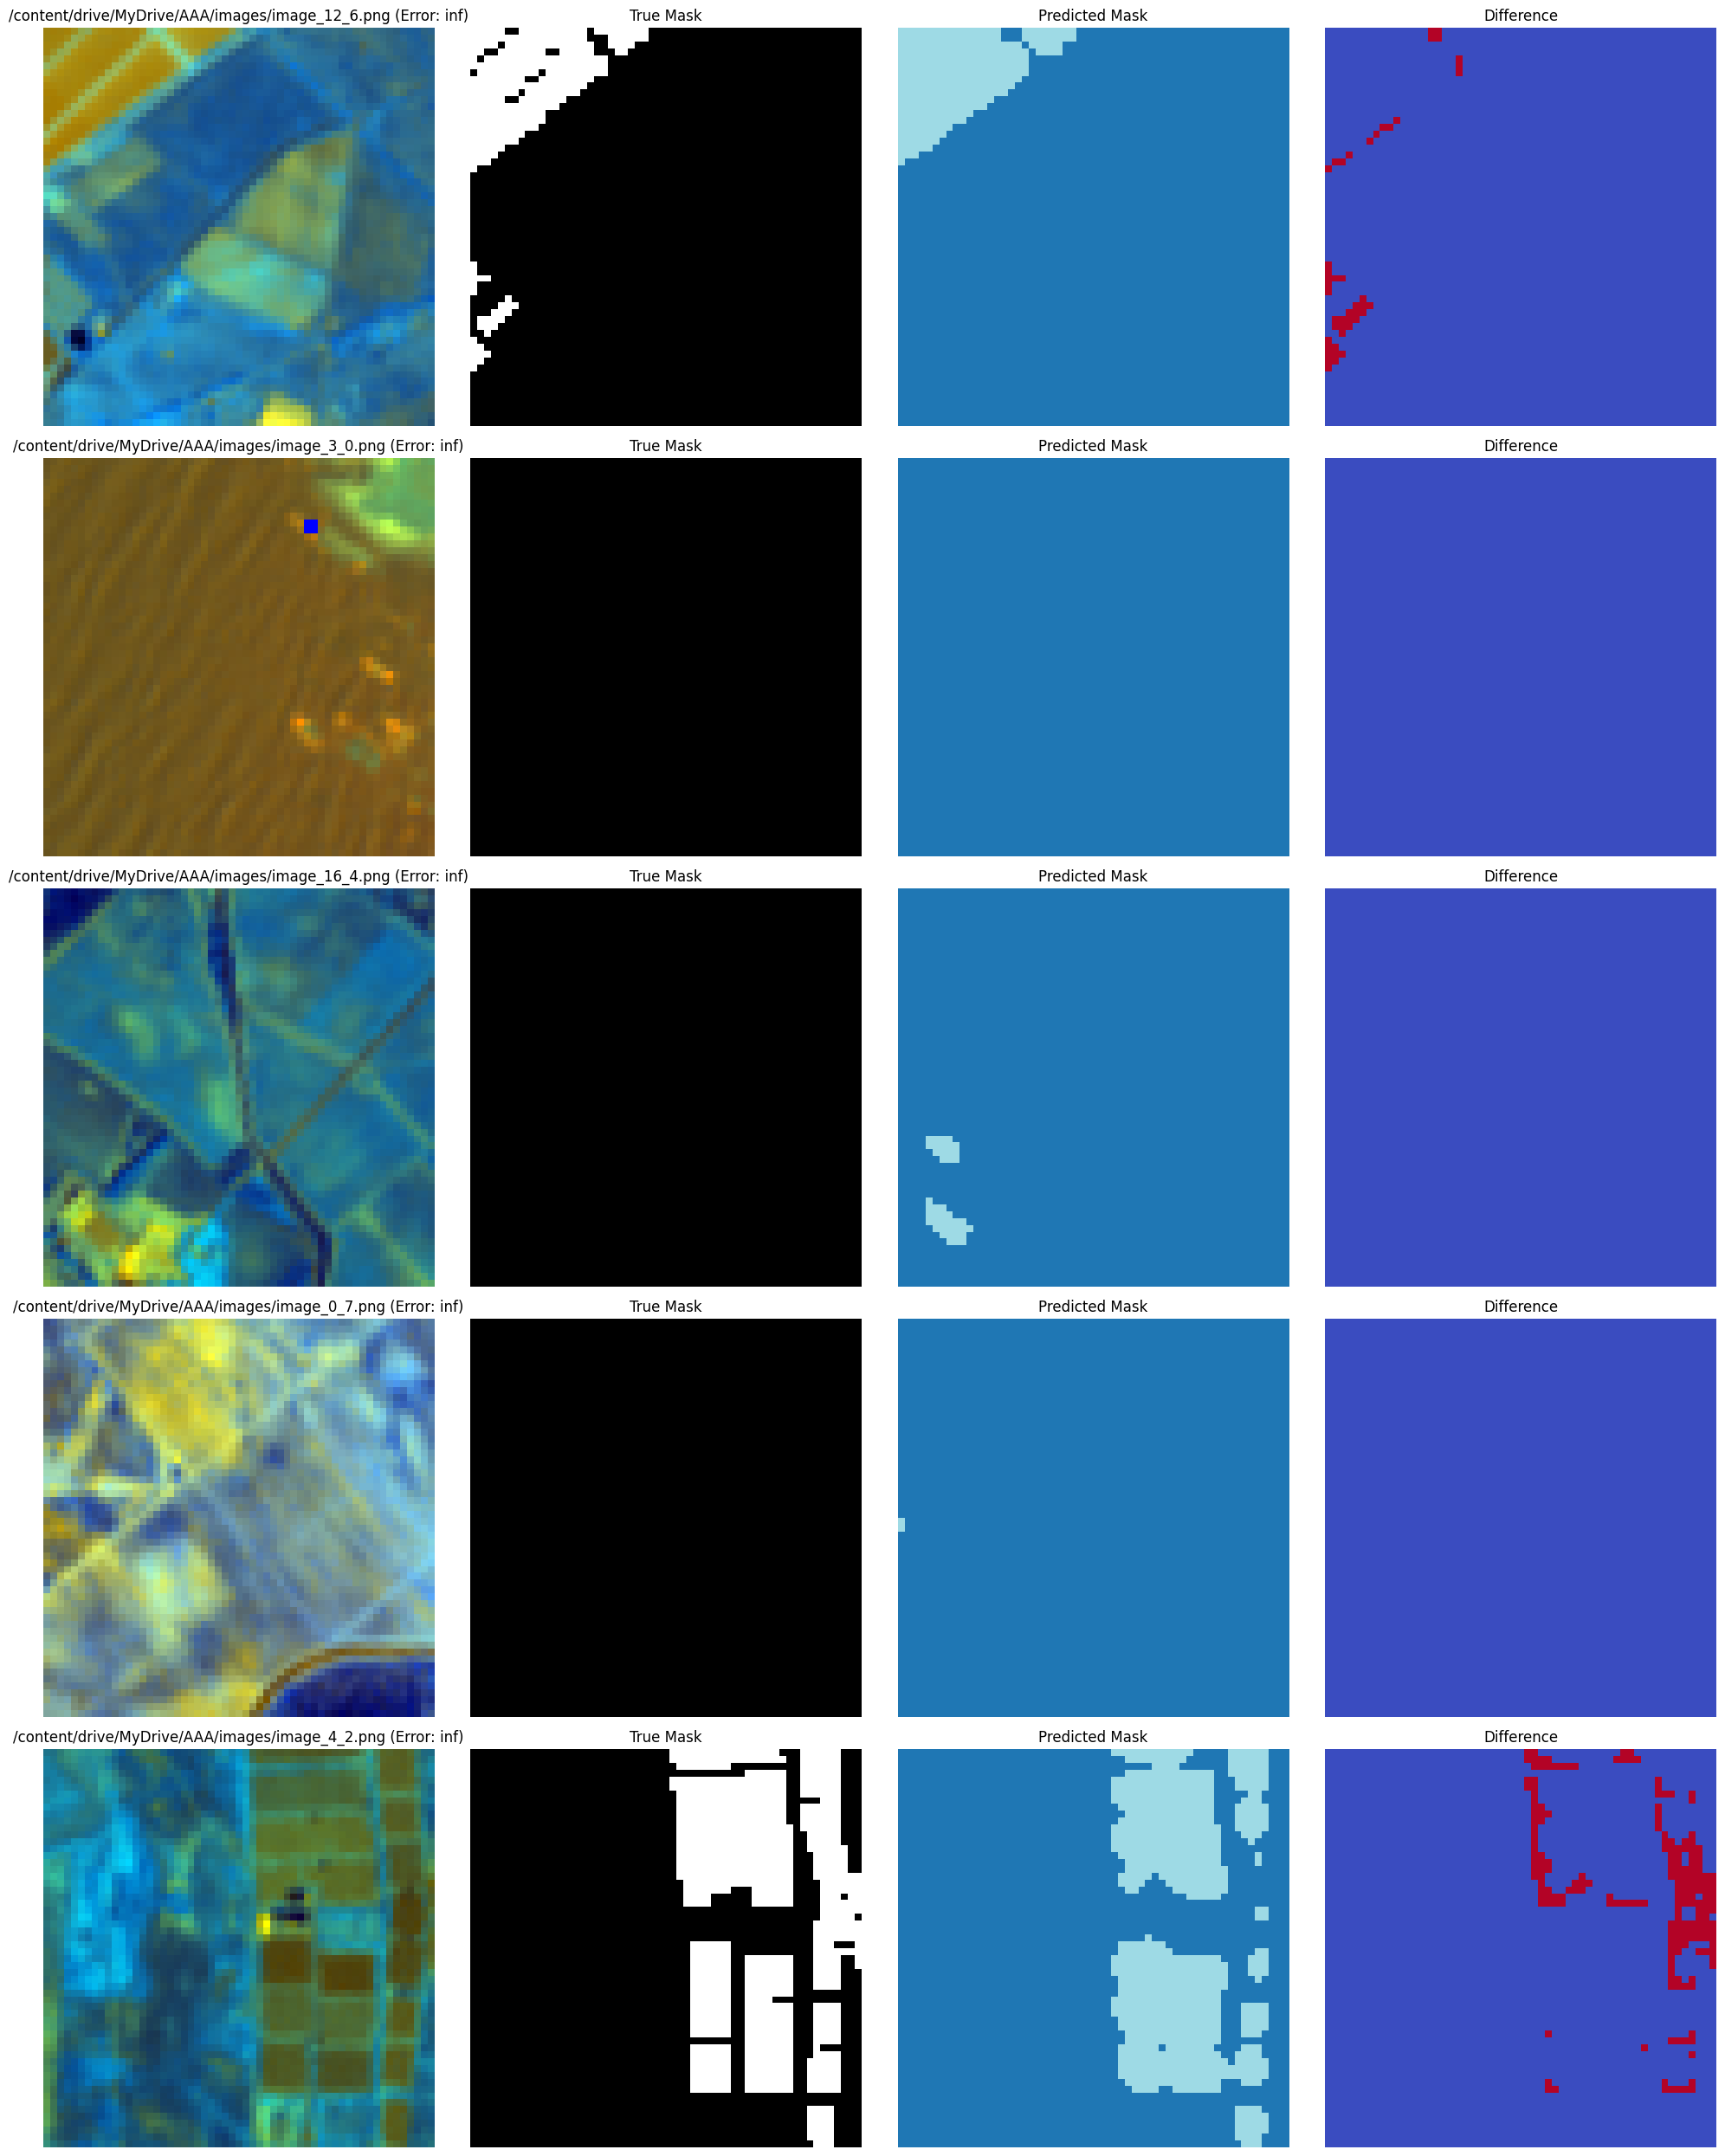

In [17]:
# Calculate pixel-wise errors and store them in a dictionary
errors = {}

for file_name in test_set_files:
    # Load the ground truth mask for the sample from the "labels1" folder
    row, column = get_row_column_from_filename(file_name)
    mask_file = mask_folder / f'image_{row}_{column}_mask.png'
    true_mask = np.array(Image.open(mask_file))

    # Load the predicted mask for the sample from the "predicted" folder
    predicted_file = os.path.join(predicted_folder, f'row_{row}', f'image_{row}_{column}_predicted.png')
    pred_mask = np.array(Image.open(predicted_file))

    # Calculate the pixel-wise error between the true mask and predicted mask
    error = np.sum(np.abs(true_mask - pred_mask))
    errors[file_name] = error

# Sort the blocks by error in descending order
sorted_errors = {k: v for k, v in sorted(errors.items(), key=lambda item: item[1], reverse=True)}

# Get the file names of the blocks with the highest errors
top_5_blocks = list(sorted_errors.keys())[:5]

# Display the top 5 blocks with the highest errors
num_columns = 4

fig, axes = plt.subplots(len(top_5_blocks), num_columns, figsize=(20, 5 * len(top_5_blocks)))

for i, file_name in enumerate(top_5_blocks):
    sample_image_path = image_folder / file_name
    sample_image = PILImage.create(sample_image_path)

    # Load the ground truth mask for the sample from the "labels1" folder
    row, column = get_row_column_from_filename(file_name)
    mask_file = mask_folder / f'image_{row}_{column}_mask.png'
    true_mask = np.array(Image.open(mask_file))

    # Load the predicted mask for the sample from the "predicted" folder
    predicted_file = os.path.join(predicted_folder, f'row_{row}', f'image_{row}_{column}_predicted.png')
    pred_mask = np.array(Image.open(predicted_file))

    # Display the satellite aggregate image with file name as title
    axes[i, 0].imshow(sample_image)
    axes[i, 0].set_title(file_name + " (Error: " + str(errors[file_name]) + ")")
    axes[i, 0].axis('off')

    # Display the true mask
    axes[i, 1].imshow(true_mask, cmap='gray')
    axes[i, 1].set_title('True Mask')
    axes[i, 1].axis('off')

    # Display the predicted mask
    axes[i, 2].imshow(pred_mask, cmap='tab20')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

    # Display the difference between true and predicted masks
    difference_mask = true_mask - pred_mask
    axes[i, 3].imshow(difference_mask, cmap='coolwarm', vmin=-1, vmax=1)
    axes[i, 3].set_title('Difference')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

## Confusion Matrix for Validation set

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Perform inference on the test set
preds, _ = learn.get_preds(dl=dls.valid)

# Convert the predicted masks to a numpy array
predicted_masks = preds.argmax(dim=1).numpy()

# Get the ground truth masks for the test set
true_masks = [y for _, y in dls.valid]

# Convert the list of true masks to a numpy array
true_masks = torch.cat(true_masks).cpu().numpy()

# Flatten the masks to be 1D arrays
true_masks_flat = true_masks.ravel()
predicted_masks_flat = predicted_masks.ravel()

# Calculate the confusion matrix for the test set
conf_matrix = confusion_matrix(true_masks_flat, predicted_masks_flat)

print("Confusion Matrix for the Test Set:")
print(conf_matrix)


Confusion Matrix for the Test Set:
[[93192  6219]
 [ 1382  4999]]


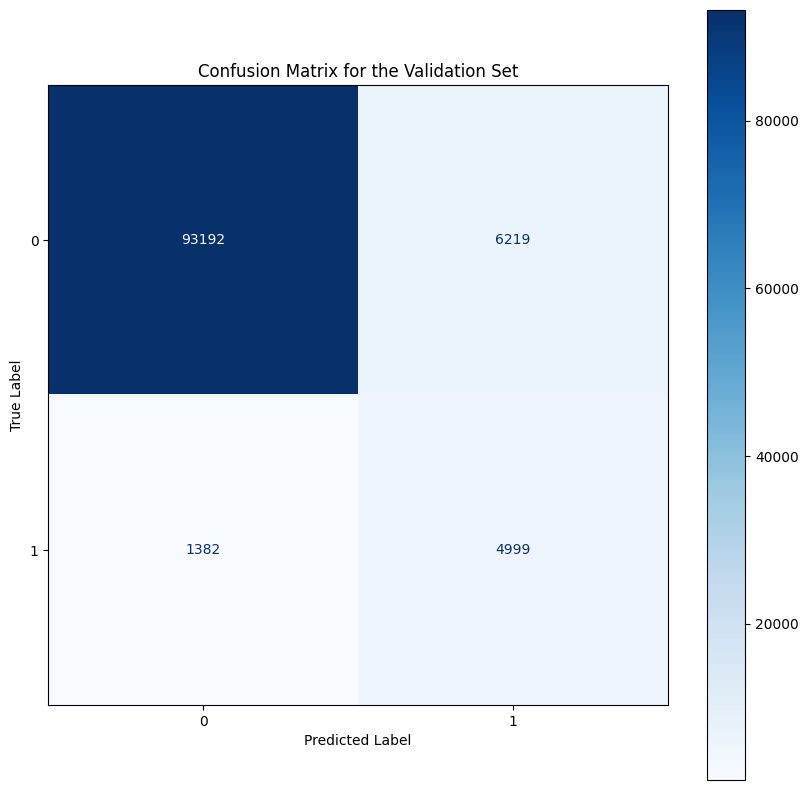

In [19]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues', ax=ax)

# Set the title and axis labels
ax.set_title('Confusion Matrix for the Validation Set')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()

## Model Accuracy for Validation set

In [20]:
# Calculate the total number of pixels
total_pixels = len(true_masks_flat)

# Calculate the number of correctly predicted pixels (True Positives + True Negatives)
correct_pixels = np.sum(true_masks_flat == predicted_masks_flat)

# Calculate the model accuracy
accuracy = correct_pixels / total_pixels

print("Model Accuracy for the Test Set: {:.2f}%".format(accuracy * 100))

Model Accuracy for the Test Set: 92.82%


In [21]:
# Calculate and print the classification report
report = classification_report(true_masks_flat, predicted_masks_flat, target_names=target_names)
print("\nClassification Report for the Test Set:")
print(report)


Classification Report for the Test Set:
                precision    recall  f1-score   support

not greenhouse       0.99      0.94      0.96     99411
    greenhouse       0.45      0.78      0.57      6381

      accuracy                           0.93    105792
     macro avg       0.72      0.86      0.76    105792
  weighted avg       0.95      0.93      0.94    105792



Cross Validation

In [22]:
from sklearn.model_selection import KFold


In [ ]:
# Specify the number of folds
num_folds = 5

# Create a K-Fold splitter
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define a function to train and evaluate the model for each fold
def train_and_evaluate_fold(fold_idx, train_idx, test_idx):
    # Create DataBlock for this fold
    dblock_fold = DataBlock(blocks=(ImageBlock, MaskBlock(target_names)),
                            get_items=get_items,
                            get_y=get_mask_fn,
                            splitter=IndexSplitter(test_idx))

    # Create DataLoaders for this fold
    dls_fold = dblock_fold.dataloaders(path, bs=8)

    # Create a U-Net model for this fold
    learn_fold = unet_learner(dls_fold, resnet34)

    # Fine-tune the model for this fold
    learn_fold.fine_tune(N_epochs)

    # Evaluate the model on the validation set
    metrics = learn_fold.validate()
    print(f"Fold {fold_idx + 1} - Metrics: {metrics}")

# Iterate over the folds
for fold_idx, (train_idx, test_idx) in enumerate(kf.split(items)):
    print(f"Fold {fold_idx + 1} of {num_folds}")
    train_and_evaluate_fold(fold_idx, train_idx, test_idx)


Fold 1 of 5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,0.456471,0.381843,00:01


epoch,train_loss,valid_loss,time
0,0.296912,0.359343,00:01
1,0.275181,0.440713,00:01
2,0.268906,0.349742,00:02
3,0.265979,0.299522,00:02
4,0.239807,0.307809,00:01
5,0.231840,0.334448,00:01
6,0.218810,0.310611,00:01
7,0.194976,0.412330,00:01
8,0.175765,0.529520,00:01
9,0.192604,0.252521,00:01


Fold 1 - Metrics: [0.4218543469905853]
Fold 2 of 5


epoch,train_loss,valid_loss,time
0,0.490255,0.284585,00:01


epoch,train_loss,valid_loss,time
0,0.320460,0.274641,00:02
1,0.307984,0.295497,00:02
2,0.294680,0.284075,00:01
3,0.303890,0.275681,00:01
4,0.356616,0.284425,00:01
5,0.340610,0.250483,00:01
6,0.551629,0.276025,00:01
7,0.481215,0.254930,00:02
8,0.441600,0.321461,00:02
9,0.399429,0.265389,00:01


Fold 2 - Metrics: [0.2380671203136444]
Fold 3 of 5


epoch,train_loss,valid_loss,time
0,0.399742,0.288331,00:02


epoch,train_loss,valid_loss,time
0,0.318961,0.270309,00:02
1,0.313653,0.268358,00:01
2,0.300411,0.233690,00:01
3,0.292386,0.245894,00:01
4,0.269871,0.345096,00:01
5,0.239509,0.266435,00:01
6,0.211522,0.440536,00:02
7,0.216612,0.395415,00:02
8,0.201742,0.268236,00:01
9,0.177269,0.367389,00:01


Exception ignored in: <function _releaseLock at 0x786ed08f2290>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


In [ ]:
# Specify the number of folds
num_folds = 5

# Create a K-Fold splitter
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define a list to store precision scores for each fold
precision_scores = []

# Define a function to train and evaluate the model for each fold
def train_and_evaluate_fold(fold_idx, train_items, test_items):
    # Create DataBlock for this fold
    dblock_fold = DataBlock(blocks=(ImageBlock, MaskBlock(target_names)),
                            get_items=get_items,
                            get_y=get_mask_fn,
                            splitter=IndexSplitter(test_items))

    # Create DataLoaders for this fold
    dls_fold = dblock_fold.dataloaders(path, bs=8)

    # Create a U-Net model for this fold
    learn_fold = unet_learner(dls_fold, resnet34)

    # Fine-tune the model for this fold
    learn_fold.fine_tune(N_epochs)

    # Evaluate the model on the validation set
    metrics = learn_fold.validate()

    # Extract and store the precision metric (assumes 'precision' is part of the metrics)
    precision = metrics[2]
    precision_scores.append(precision)

    print(f"Fold {fold_idx + 1} - Precision: {precision}")

# Iterate over the folds
for fold_idx, (train_items, test_items) in enumerate(kf.split(items)):
    print(f"Fold {fold_idx + 1} of {num_folds}")
    print(f"Train indices: {train_items}")
    print(f"Test indices: {test_items}")
    train_and_evaluate_fold(fold_idx, train_items, test_items)

In [ ]:
# Calculate and print the mean precision across folds
mean_precision = np.mean(precision_scores)
print(f"Mean Precision: {mean_precision}")

In [ ]:
# Load the ground truth TIFF mask and predicted PNG mask
with rasterio.open(os.path.join(directory, 'mask_3763_reclass.tif')) as tiff_mask:
    ground_truth_mask = tiff_mask.read(1)  # Assuming it's a one-band TIFF

# Load the predicted PNG mask
predicted_mask = Image.open(os.path.join(predicted_folder, 'merged_predicted_masks_20_1209.png'))
# Convert the predicted mask to grayscale
predicted_mask = predicted_mask.convert('L')
# Resize the predicted mask to match the dimensions of the ground truth mask
predicted_mask = predicted_mask.resize(ground_truth_mask.shape[::-1], Image.ANTIALIAS)
# Convert to a NumPy array
predicted_mask = np.array(predicted_mask)

In [ ]:
# Create an aligned predicted mask with the same values as the ground truth mask
aligned_predicted_mask = np.array(predicted_mask)

# Identify commission errors (false positives)
commission_errors = (aligned_predicted_mask == 1) & (ground_truth_mask == 0)

# Identify omission errors (false negatives)
omission_errors = (aligned_predicted_mask == 0) & (ground_truth_mask == 1)

In [ ]:
# Create a merged image for visualization
merged_image = np.zeros((ground_truth_mask.shape[0], ground_truth_mask.shape[1], 3), dtype=np.uint8)

# Mark correct identifications in green
correct_identifications = (aligned_predicted_mask == ground_truth_mask)
merged_image[correct_identifications] = [0, 255, 0]  # Green color

# Mark commission errors (false positives) in yellow
merged_image[commission_errors] = [255, 255, 0]  # Yellow color

# Mark omission errors (false negatives) in red
merged_image[omission_errors] = [255, 0, 0]  # Red color

# Display the merged image
plt.figure(figsize=(8, 6))
plt.imshow(merged_image)
plt.axis('off')
plt.title('Merged Image with Correct Identifications (Green), Commission (Yellow), and Omission (Red) Errors')
plt.show()

# Save the merged image
merged_output_file = os.path.join(predicted_folder, 'comission_omission.png')
plt.imsave(merged_output_file, merged_image)